In [3]:
import os
import textwrap
import tiktoken
import matplotlib.pyplot as plt
import numpy as np
import umap.umap_ as umap
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
#from sklearn.datasets import make_blobs
from sklearn.metrics import silhouette_score
from dotenv import load_dotenv, find_dotenv
from langchain.vectorstores import Chroma
from langchain.embeddings import OpenAIEmbeddings
from langchain.text_splitter import RecursiveCharacterTextSplitter
from langchain.chat_models import ChatOpenAI
from langchain.document_loaders import PyPDFLoader
from langchain.document_loaders import DirectoryLoader
from langchain import PromptTemplate
from langchain_core.runnables import RunnablePassthrough
from langchain_core.output_parsers import StrOutputParser
from typing import Optional

In [4]:
load_dotenv(find_dotenv())
embeddings = OpenAIEmbeddings()

turbo_llm = ChatOpenAI(
    temperature=0.7,
    model_name='gpt-3.5-turbo-0125'
)

In [5]:
# Carga de documentos y extracción de información
# (asegúrate de que haya PDFs en la carpeta documentos)
documents = DirectoryLoader('./documentos/', glob="./*.pdf", loader_cls=PyPDFLoader).load()
# Tratameinto de caracteres indeseados
for d in documents:
    d.page_content = d.page_content.replace('\n', ' ').replace('\t', ' ')
# Separador de texto (límita el texto para que sea soportado por el LLM)
text_splitter = RecursiveCharacterTextSplitter(
    chunk_size=3000,
    chunk_overlap=500
)
docs = text_splitter.split_documents(documents)
texts = [doc.page_content for doc in docs]

In [6]:
def num_tokens_from_string(string: str) -> int:
    encoding = tiktoken.get_encoding("cl100k_base")
    num_tokens = len(encoding.encode(string))
    return num_tokens

counts = [num_tokens_from_string(t) for t in texts]

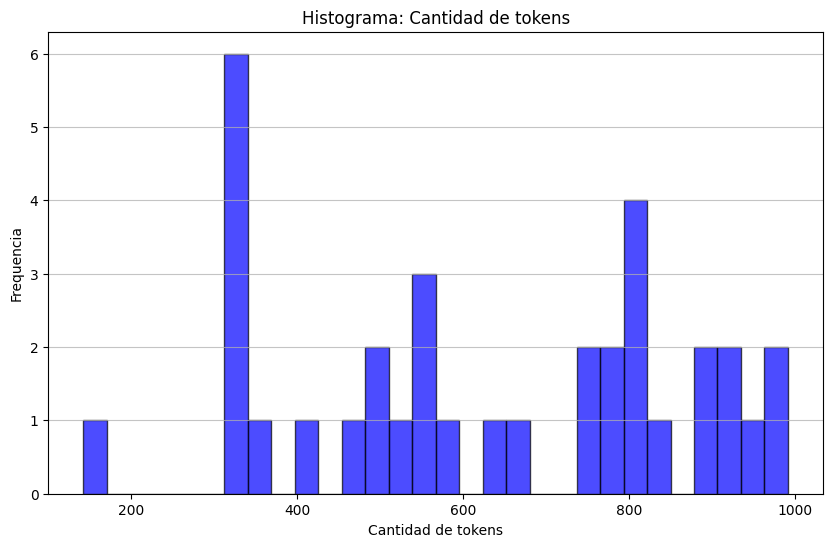

In [8]:
plt.figure(figsize=(10, 6))
plt.hist(counts, bins=30, color="blue", edgecolor="black", alpha=0.7)
plt.title("Histograma: Cantidad de tokens")
plt.xlabel("Cantidad de tokens")
plt.ylabel("Frequencia")
plt.grid(axis="y", alpha=0.75)
plt.show()

In [9]:
d_sorted = sorted(docs, key=lambda x: x.metadata["source"])
d_reversed = list(reversed(d_sorted))
concatenated_content = "\n\n\n --- \n\n\n".join(
    [doc.page_content for doc in d_reversed]
)
print(
    "Num tokens in all context: %s"
    % num_tokens_from_string(concatenated_content)
)

Num tokens in all context: 22157


In [10]:
global_embeddings = [embeddings.embed_query(txt) for txt in texts]

In [11]:
def reduce_cluster_embeddings(
    embeddings: np.ndarray,
    dim: int,
    n_neighbors: Optional[int] = None,
    metric: str = "cosine",
) -> np.ndarray:
    if n_neighbors is None:
        n_neighbors = int((len(embeddings) - 1) ** 0.5)
    return umap.UMAP(
        n_neighbors=n_neighbors, n_components=dim, metric=metric
    ).fit_transform(embeddings)

dim = 2
global_embeddings_reduced = reduce_cluster_embeddings(global_embeddings, dim)
global_embeddings_reduced

array([[5.50294  , 7.6111913],
       [4.5512967, 5.120285 ],
       [4.719974 , 5.1165714],
       [6.070657 , 7.0501366],
       [5.7662525, 7.227627 ],
       [5.5940695, 6.6252837],
       [4.7462945, 5.5002904],
       [6.547814 , 5.1380982],
       [6.272488 , 7.703571 ],
       [7.0713944, 8.298893 ],
       [5.897223 , 6.0521092],
       [7.305511 , 7.607091 ],
       [6.8212185, 7.863519 ],
       [6.790841 , 8.305852 ],
       [5.845198 , 5.4250383],
       [7.096796 , 5.5945816],
       [6.8853955, 6.804949 ],
       [7.1590157, 5.8141346],
       [5.0752964, 6.052634 ],
       [7.3155894, 8.012783 ],
       [6.3731937, 7.3354177],
       [5.329146 , 5.2932005],
       [6.997253 , 5.334212 ],
       [5.2925844, 7.4947433],
       [3.046524 , 7.5519466],
       [3.8058567, 6.4707513],
       [3.3039532, 7.019468 ],
       [3.56312  , 7.0846825],
       [2.909943 , 7.69696  ],
       [3.9124591, 6.1162496],
       [4.034945 , 7.6542573],
       [4.1170373, 7.212274 ],
       [

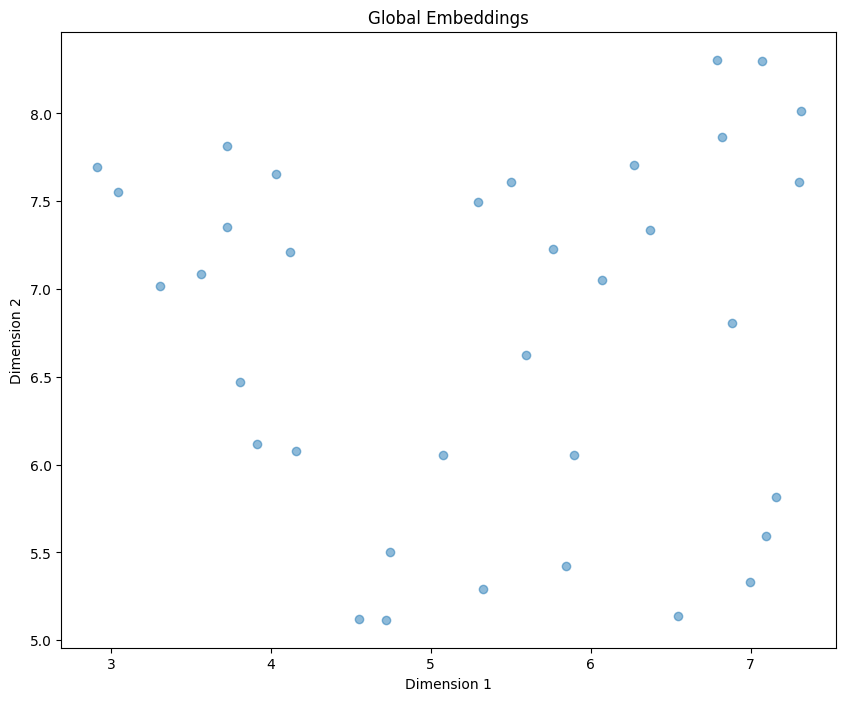

In [12]:
plt.figure(figsize=(10, 8))
plt.scatter(global_embeddings_reduced[:, 0], global_embeddings_reduced[:, 1], alpha=0.5)
plt.title("Global Embeddings")
plt.xlabel("Dimension 1")
plt.ylabel("Dimension 2")
plt.show()

c:\Users\luisr\OneDrive\Documentos\GitHub\1day_1thing\.venv\Lib\site-packages\joblib\externals\loky\backend\context.py:136: UserWarning: Could not find the number of physical cores for the following reason:
found 0 physical cores < 1
Returning the number of logical cores instead. You can silence this warning by setting LOKY_MAX_CPU_COUNT to the number of cores you want to use.
  warnings.warn(
  File "c:\Users\luisr\OneDrive\Documentos\GitHub\1day_1thing\.venv\Lib\site-packages\joblib\externals\loky\backend\context.py", line 282, in _count_physical_cores
    raise ValueError(f"found {cpu_count_physical} physical cores < 1")


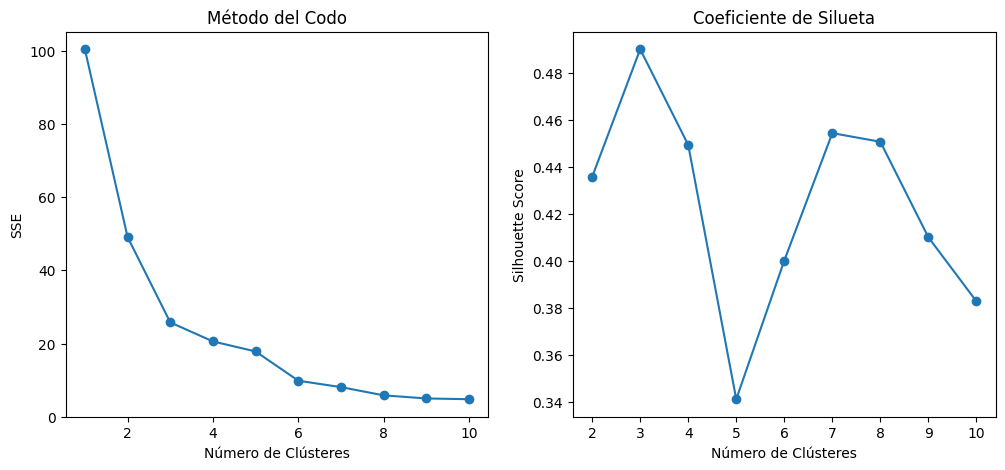

In [13]:

# Método del Codo
sse = []
k_values = range(1, 11)
for k in k_values:
    kmeans = KMeans(n_clusters=k, random_state=0).fit(global_embeddings_reduced)
    sse.append(kmeans.inertia_)

# Coeficiente de Silueta
silhouette_scores = []
for k in k_values[1:]:  # Silhouette score no está definido para k=1
    kmeans = KMeans(n_clusters=k, random_state=0).fit(global_embeddings_reduced)
    score = silhouette_score(global_embeddings_reduced, kmeans.labels_)
    silhouette_scores.append(score)

# Graficar el método del codo
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(k_values, sse, marker='o')
plt.title('Método del Codo')
plt.xlabel('Número de Clústeres')
plt.ylabel('SSE')

# Graficar el coeficiente de silueta
plt.subplot(1, 2, 2)
plt.plot(k_values[1:], silhouette_scores, marker='o')
plt.title('Coeficiente de Silueta')
plt.xlabel('Número de Clústeres')
plt.ylabel('Silhouette Score')

plt.show()

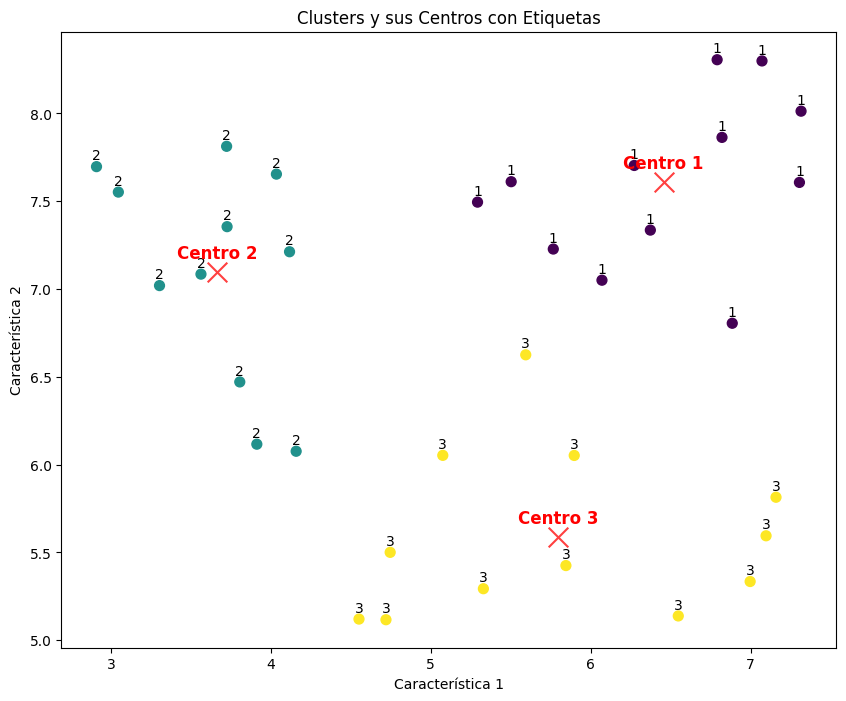

In [14]:
# Suponiendo que 'global_embeddings_reduced' ya está definido
optimal_k = 3

kmeans = KMeans(n_clusters=optimal_k, random_state=0).fit(global_embeddings_reduced)
labels = kmeans.labels_ + 1  # Agregar 1 a las etiquetas de los clústeres
centers = kmeans.cluster_centers_

# Visualizar los datos y los centros de los clústeres
plt.figure(figsize=(10, 8))
plt.scatter(global_embeddings_reduced[:, 0], global_embeddings_reduced[:, 1], c=labels, s=50, cmap='viridis')
plt.scatter(centers[:, 0], centers[:, 1], c='red', s=200, alpha=0.75, marker='x')

# Añadir etiquetas a los puntos de datos
for i in range(len(global_embeddings_reduced)):
    plt.annotate(str(labels[i]), (global_embeddings_reduced[i, 0], global_embeddings_reduced[i, 1]),
                 textcoords="offset points", xytext=(0,5), ha='center')

# Añadir etiquetas a los centros de los clústeres
for i, center in enumerate(centers):
    plt.annotate(f'Centro {i+1}', (center[0], center[1]), textcoords="offset points", xytext=(0,10), ha='center', color='red', fontsize=12, weight='bold')

plt.title("Clusters y sus Centros con Etiquetas")
plt.xlabel("Característica 1")
plt.ylabel("Característica 2")
plt.show()

In [15]:
print(len(texts))
print(len(global_embeddings_reduced))

35
35


In [16]:
df = pd.DataFrame({
    'Texto': texts,
    'Embedding': list(global_embeddings_reduced),
    'Cluster': labels
})
df.head()

,Texto,Embedding,Cluster
0,Depósito legal ppi 201502ZU4662 Esta publicaci...,"[5.50294, 7.6111913]",1
1,Disponible en: https://produccioncientificaluz...,"[4.5512967, 5.120285]",3
2,108Licencia de Creative Commons Atribución 4....,"[4.719974, 5.1165714]",3
3,"la obtención de ganancias, siendo una condici...","[6.070657, 7.0501366]",1
4,"109 Revista de Ciencias Sociales, Vol. XXIX, N...","[5.7662525, 7.227627]",1


In [17]:
def format_cluster_texts(df):
    clustered_texts = {}
    for cluster in df['Cluster'].unique():
        cluster_texts = df[df['Cluster'] == cluster]['Texto'].tolist()
        clustered_texts[cluster] = " --- ".join(cluster_texts)
    return clustered_texts

clustered_texts = format_cluster_texts(df)
clustered_texts

{1: 'Depósito legal ppi 201502ZU4662 Esta publicación científica en formato digital es continuidad de la revista impresa Depósito Legal: pp 197402ZU789 ● ISSN: 1315-9518 ● ISSN-E: 2477-9431 Esta publicación científica en formato digital es continuidad de la revista impresa Depósito Legal: pp 197402ZU789 ISSN: 1315-9518Universidad del Zulia. Revista de la Facultad de Ciencias Económicas y Sociales Vol. XXIX, No. 4                                                    OCTUBRE-DICIEMBRE 2023 --- la obtención de ganancias, siendo  una condición tecnológica inherente a todos  los problemas de eficiencia y eficacia (Caird,  1992; Campo-Ternera et al., 2018; Velázquez, Cruz y Vargas, 2018; Vega, Bautista y  Martínez, 2020; Medina y Espinosa, 2022).  Por su parte, Albornoz (2009), lo describe  como la búsqueda de mejores condiciones  competitivas desde las empresas a través de  la investigación básica y la tecnología. Es así  que la innovación se compone de una serie  de actividades, no solamente

# Hay que volver a hacer un split de texto para solucionar problemas de capacidad en el LLM.

In [18]:
template = """Eres un asistente capaz de crear resumenes detallados y concisos del texto proporcionado.

Texto:
{text}
"""

prompt = PromptTemplate.from_template(template)
chain = prompt | turbo_llm | StrOutputParser()

In [19]:
summaries = {}
for cluster, text in clustered_texts.items():
    summary = chain.invoke({"text": text})
    summaries[cluster] = summary

summaries

{1: 'La publicación científica en formato digital es una continuación de la revista impresa de la Universidad del Zulia, abordando temas como la innovación, la eficiencia y la eficacia en las empresas. Se destaca la importancia de la innovación en las pequeñas y medianas empresas (pyme) y su relación con el desempeño, el empleo y el desarrollo de modelos de ventajas competitivas. Se analiza también la gestión del riesgo, la sustentabilidad y el rendimiento de las pyme, así como la relevancia de la innovación incremental en el desarrollo empresarial. \n\nSe identifican tendencias en investigación en diferentes continentes, como Asia, Europa, América y Oceanía, donde se aborda la incorporación de las Tecnologías de Información y Comunicación (TIC) en los procesos de innovación. Se examinan también las políticas públicas relacionadas con la innovación en las pyme en distintos países. \n\nSe utilizan diversas técnicas metodológicas como entrevistas, análisis de contenido y modelos de ecuac

In [20]:
clustered_summaries = {}
for label, summary in zip(labels, summaries.values()):
    if label not in clustered_summaries:
        clustered_summaries[label] = []
    clustered_summaries[label].append(summary)

clustered_summaries

{1: ['La publicación científica en formato digital es una continuación de la revista impresa de la Universidad del Zulia, abordando temas como la innovación, la eficiencia y la eficacia en las empresas. Se destaca la importancia de la innovación en las pequeñas y medianas empresas (pyme) y su relación con el desempeño, el empleo y el desarrollo de modelos de ventajas competitivas. Se analiza también la gestión del riesgo, la sustentabilidad y el rendimiento de las pyme, así como la relevancia de la innovación incremental en el desarrollo empresarial. \n\nSe identifican tendencias en investigación en diferentes continentes, como Asia, Europa, América y Oceanía, donde se aborda la incorporación de las Tecnologías de Información y Comunicación (TIC) en los procesos de innovación. Se examinan también las políticas públicas relacionadas con la innovación en las pyme en distintos países. \n\nSe utilizan diversas técnicas metodológicas como entrevistas, análisis de contenido y modelos de ecua

In [21]:
final_summaries = {}
for cluster, texts in clustered_summaries.items():
    combined_text = ' '.join(texts)
    summary = chain.invoke({"text": combined_text})
    final_summaries[cluster] = summary

final_summaries

{1: 'La publicación científica digital aborda la importancia de la innovación en las pequeñas y medianas empresas (pyme) y su relación con el desempeño, el empleo y el desarrollo de ventajas competitivas. Se analiza la gestión del riesgo, la sustentabilidad y el rendimiento de las pyme, así como la relevancia de la innovación incremental en el desarrollo empresarial. Se identifican tendencias de investigación en diferentes continentes, se examinan políticas públicas relacionadas con la innovación en las pyme y se utilizan diversas técnicas metodológicas para analizar su impacto en los sectores económicos. Se destaca la importancia de la colaboración, la investigación y el desarrollo en la generación de conocimiento científico en este ámbito.',
 3: 'La investigación se centró en analizar la innovación en las pequeñas y medianas empresas a nivel global, utilizando técnicas cualitativas y cuantitativas. Se encontró que en el periodo anterior predominaron los estudios cuantitativos, mientr

In [22]:
texts_from_df = df['Texto'].tolist()
texts_from_clustered_texts = list(clustered_texts.values())
texts_from_final_summaries = list(final_summaries.values())

combined_texts = texts_from_df + texts_from_clustered_texts + texts_from_final_summaries

### 1. Enseñar

In [23]:
persist_directory = input('¿Cómo se llama este knoledge-base?: ') + '_kb'
vectorstore = Chroma.from_texts(texts=combined_texts,
                                embedding=embeddings,
                                persist_directory=persist_directory)
vectorstore.persist()
vectorstore = None
os.system(f'zip -r db.zip ./{persist_directory}')

c:\Users\luisr\OneDrive\Documentos\GitHub\1day_1thing\.venv\Lib\site-packages\langchain_core\_api\deprecation.py:119: LangChainDeprecationWarning: Since Chroma 0.4.x the manual persistence method is no longer supported as docs are automatically persisted.
  warn_deprecated(


1

### 2. Recordar (si y solo si Enseñar=Done)

In [30]:
persist_directory = input('¿Qué knoledge-base deseas usar?: ') + '_kb'
embedding = OpenAIEmbeddings()
vectorstore = Chroma(persist_directory=persist_directory, 
                  embedding_function=embedding)

def adjust_final_number(string: str, max_threshold: int, initial_number: int) -> int:
    final_number = initial_number
    while final_number < max_threshold:
        retriever = vectorstore.as_retriever(search_kwargs={"k": final_number})
        docs = retriever.get_relevant_documents(string)
        text = "".join([doc.page_content for doc in docs])
        if num_tokens_from_string(text) < max_threshold:
            final_number += 1
        else:
            break
    return final_number

final_number = adjust_final_number("¿Cuál es el tema pricipal del documento?", 10000, 4)
print(final_number)
retriever = vectorstore.as_retriever(search_kwargs={"k": final_number})

8


In [31]:
# Se personaliza el LLM
template = """
Eres Prometeo, un asistente personal de lectura que habla Español.

Tu tarea consiste en:

1. Ser carismático y ofrecer información sobre ti y tus funciones.

2. Leer detalladamente la información proporcionada en documentos
de texto en formato PDF, para ser capaz de dar respuestas a cualquier tipo de pregunta,
en especial a preguntas puntuales.

SIEMPRE debes responder con base al contexto proporcionado aqui: {context}.
        
Si no sabes la respuesta, puedes decir: 'No sé'.

NUNCA hables del contexto.

Teniendo lo anterior en cuenta, responde la siguiente pregunta: {question}
"""

prometeo_prompt = PromptTemplate(
    template=template, input_variables=["context", "question"]
)

def format_docs(docs):
    return "\n\n".join(doc.page_content for doc in docs)

rag_chain = (
    {"context": retriever | format_docs, "question": RunnablePassthrough()}
    | prometeo_prompt
    | turbo_llm
    | StrOutputParser()
)

In [32]:
# Demo
query = input("Hazme una pregunta: ")
print(query)
llm_response = rag_chain.invoke(query)
wrapper = textwrap.TextWrapper(width=70) 
word_list = wrapper.wrap(text=llm_response) 

# Print each line. 
for element in word_list: 
    print(element)

¿Cómo se aplicaron los estudios según enfoque y método?
Los estudios se aplicaron tanto desde un enfoque cualitativo como
cuantitativo. En cuanto al enfoque cualitativo, se utilizaron técnicas
como el análisis documental, estudios de caso, entrevistas, análisis
de contenido y observación directa. Por otro lado, desde un enfoque
cuantitativo, se observó la aplicación de técnicas como encuestas,
estudios econométricos, ecuaciones estructurales, bibliometría,
evaluación sintética, análisis de redes sociales y extracción de
elementos dominantes. En general, se evidenció una mayor prevalencia
de estudios cuantitativos en el análisis de la innovación en las
pequeñas y medianas empresas.


In [ ]:
# Demo
query = input("Hazme una pregunta: ")
print(query)
llm_response = rag_chain.invoke(query)
wrapper = textwrap.TextWrapper(width=70) 
word_list = wrapper.wrap(text=llm_response) 

# Print each line. 
for element in word_list: 
    print(element)

In [ ]:
# Demo
query = input("Hazme una pregunta: ")
print(query)
llm_response = rag_chain.invoke(query)
wrapper = textwrap.TextWrapper(width=70) 
word_list = wrapper.wrap(text=llm_response) 

# Print each line. 
for element in word_list: 
    print(element)

In [ ]:
# Demo
query = input("Hazme una pregunta: ")
print(query)
llm_response = rag_chain.invoke(query)
wrapper = textwrap.TextWrapper(width=70) 
word_list = wrapper.wrap(text=llm_response) 

# Print each line. 
for element in word_list: 
    print(element)

In [ ]:
# Demo
query = input("Hazme una pregunta: ")
print(query)
llm_response = rag_chain.invoke(query)
wrapper = textwrap.TextWrapper(width=70) 
word_list = wrapper.wrap(text=llm_response) 

# Print each line. 
for element in word_list: 
    print(element)

### 2. Recordar (si y solo si Enseñar=Done)

In [ ]:
# Now we can load the persisted database from disk, and use it as normal. 
persist_directory = input('¿Qué knoledge-base deseas usar?: ') + '_kb'
embedding = OpenAIEmbeddings()
vectordb = Chroma(persist_directory=persist_directory, 
                  embedding_function=embedding)
retriever = vectordb.as_retriever(search_kwargs={"k": 5})
#retriever = vectordb.as_retriever()